# Digit Classification with ANN with Keras and Pytorch

In this notebook we will be revisiting the problem of digit classification on the MNIST data. In doing so, we will implement the same neural network with both **Keras** and **PyTorch** and get a hang on implementation of these two frameworks. We will start with feed forward neural network and then explore Convolutional Neural Network. For Keras I will simply use Tensorflow 2.

The input layer consists of 28 x 28 (=784) greyscale pixels which constitute the input data of the MNIST data set. This input is then passed through a fully connected hidden layers with 50 nodes, with the nodes utilizing a ReLU activation function. Finally, we have an output layer with ten nodes corresponding to the 10 possible classes of hand-written digits (i.e. 0 to 9). We will use a softmax output layer to perform this classification.


## 1. Get all the imports at one place

In [144]:
%matplotlib inline
#%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
import time

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.utils as utils
from tensorflow.keras.datasets import mnist
np.random.seed(0)

import tensorflow as tf
print("Tensorflow version", tf.__version__)

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision

Tensorflow version 2.2.0


## 2. Load MNIST data

Many frameworks come with the mnist dataset bundled with it. Here we will see how to load the data both by sklearn and Keras. We will use the one from Keras.

### a. Load the mnist dataset from sklearn utility

In [3]:
# Load the mnist dataset from sklearn utility
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


### b. Load the mnist dataset from keras utility

In [36]:
(x_train, train_labels), (x_test, test_labels) = mnist.load_data()

#Reshape the training data
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

shape = x_train.shape
numTrainExamples = x_train.shape[0]
numTestExamples = x_test.shape[0]
print ('shape of data = ' ,shape)
print ('Train set = %d' %(numTrainExamples))
print ('Test set = %d' %(numTestExamples))



shape of data =  (60000, 784)
Train set = 60000
Test set = 10000


### c. Normalize the data

In [37]:
#Normalize the data. For images it is okay to divide each feature by 255
x_train = x_train / 255.0
x_test = x_test / 255.0

### d. Convert the labels to 1-n-encoding

Let's make these labels, rather than each being an integer value from 0-9, be a set of 10 binary values, one for each class. This is sometimes called a 1-of-n encoding, and it makes working with Neural Networks easier, as there will be one output node for each class .

In [19]:
y_train = utils.to_categorical(train_labels, num_classes=10)
y_test = utils.to_categorical(test_labels, num_classes=10)

numClasses = y_train[1].size
print ('Classes = %d' %(numClasses))

Classes = 10


## 3.  Run Baseline with Logistic Regression and Keras

Two notes relevant at this point:

First, logistic regression can be thought of as a neural network with no hidden layers. The output values are just the dot product of the inputs and the edge weights.

Second, we have 10 classes. We can either train separate one vs all classifiers using sigmoid activation, which would be a hassle, or we can use the softmax activation, which is essentially a multi-class version of sigmoid. We'll use Keras's built-in implementation of softmax.

The objective is minimize the cost, and to do that we'll use batch gradient descent.

We can use a percentage of training data as validation data and can check the accuracies after every epoch. This will give us an insight into overfitting at the time of training only and we can take steps before the completion of all epochs. 

In [16]:
## Model
model = Sequential() 
model.add(Dense(10, input_dim=784, activation='softmax')) 

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train, shuffle=False, batch_size=256, verbose=1, epochs=10,validation_split=0.2) 


Epoch 1/10
188/188 [==============================] - 0s 2ms/step - loss: 1.7422 - accuracy: 0.5300 - val_loss: 1.2587 - val_accuracy: 0.7687
Epoch 2/10
188/188 [==============================] - 0s 2ms/step - loss: 1.0864 - accuracy: 0.7858 - val_loss: 0.9037 - val_accuracy: 0.8263
Epoch 3/10
188/188 [==============================] - 0s 2ms/step - loss: 0.8550 - accuracy: 0.8208 - val_loss: 0.7471 - val_accuracy: 0.8472
Epoch 4/10
188/188 [==============================] - 0s 2ms/step - loss: 0.7387 - accuracy: 0.8374 - val_loss: 0.6588 - val_accuracy: 0.8604
Epoch 5/10
188/188 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.8475 - val_loss: 0.6017 - val_accuracy: 0.8678
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.8548 - val_loss: 0.5614 - val_accuracy: 0.8734
Epoch 7/10
188/188 [==============================] - 0s 2ms/step - loss: 0.5838 - accuracy: 0.8604 - val_loss: 0.5313 - val_accuracy: 0.8776
Epoch 

In [17]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1) 
print('Test score:', loss) 
print('Test accuracy:', accuracy)

313/313 [==============================] - 0s 628us/step - loss: 0.4791 - accuracy: 0.8838
Test score: 0.4790601432323456
Test accuracy: 0.8838000297546387


**model.get_weights(): returns a list of all weight tensors in the model, as Numpy arrays.**

**model.summary(): prints a summary representation of your model and the history give you the loass and accuracy of each epoch.**

In [19]:
model.get_weights()

[array([[-0.06302977,  0.00700452, -0.06412408, ..., -0.04437212,
         -0.05833428,  0.00402944],
        [-0.00200045,  0.01441458, -0.04651412, ..., -0.03631159,
         -0.02462959,  0.03994233],
        [-0.0582297 ,  0.0253281 , -0.05260985, ..., -0.02789539,
          0.07586228, -0.0564077 ],
        ...,
        [-0.03160532,  0.00909608, -0.0247591 , ..., -0.02036525,
         -0.07199302,  0.01902035],
        [-0.0766532 , -0.03710368, -0.02969142, ...,  0.04341201,
         -0.01856547, -0.05263744],
        [-0.01516117, -0.01239169, -0.08625276, ...,  0.01258839,
         -0.0090166 , -0.02749431]], dtype=float32),
 array([-0.06760255,  0.13678588, -0.02212849, -0.05005212,  0.05141817,
         0.10148938, -0.01192823,  0.07058349, -0.17967913, -0.02888621],
       dtype=float32)]

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### a) Plot Loss verses Accuracy curve

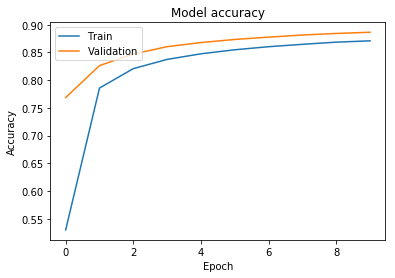

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

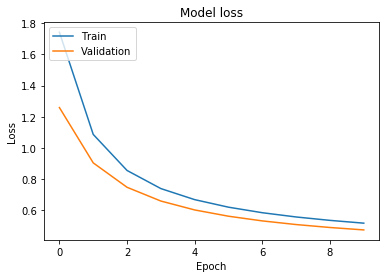

In [24]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

## 5. Multi-layer Neural Networks with Keras

Let's take our implementation of logistic regression (which recall is in fact a single layer neural network), and add a hidden layer, making it a two layer neural network. Because we have a hidden layer, we will now train the model using backpropagation. We will be using Relu activation model for the hidden layers.

The idea with dropouts is that instead of (or in addition to) adding noise to our inputs, we add noise by having each node return 0 with a certain probability during training. This trick both improves generalization in large networks and speeds up training.



In [32]:
## Model
model = Sequential() 
model.add(Dense(units=50, input_dim=784,activation='relu', name='hidden1')) 
model.add(Dropout(0.5))
model.add(Dense(units=10, input_dim=50, activation='softmax',name='output')) 

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, shuffle=True, batch_size=256, verbose=0, epochs=50,validation_split=0.2) 




In [33]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1) 
print('Test score:', loss) 
print('Test accuracy:', accuracy)

313/313 [==============================] - 0s 701us/step - loss: 0.2535 - accuracy: 0.9266
Test score: 0.25345292687416077
Test accuracy: 0.9265999794006348


### a) Plot Loss verses Accuracy curve

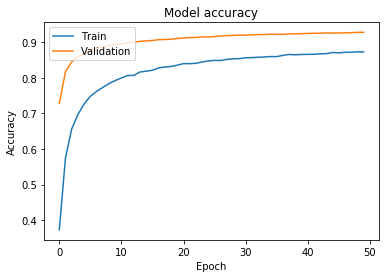

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

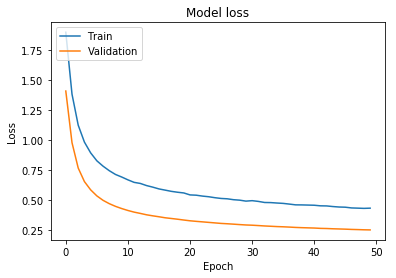

In [35]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

## 6. Multi-layer Neural Networks with PyTorch

Here we will create a simple 2-layer fully connected neural network (including an input layer and one hidden layer) to classify the hand-written digits of the MNIST dataset. The input layer consists of 28 x 28 (=784) greyscale pixels which constitute the input data of the MNIST data set. This input is then passed through a fully connected hidden layers with 50 nodes, with the nodes utilizing a ReLU activation function. Finally, we have an output layer with ten nodes corresponding to the 10 possible classes of hand-written digits (i.e. 0 to 9). We will use a softmax output layer to perform this classification.

A fully connected neural network layer is represented by the nn.Linear object, with the first argument in the definition being the number of nodes in layer l and the next argument being the number of nodes in layer l+1. As you can observer, the first layer takes the 28 x 28 input pixels and connects to the first 50 node hidden layer. Then we have the output layer with 10 nodes. 

For the forward() method, we supply the input data x as the primary argument. We feed this into our first fully connected layer (self.fc1(x)) and then apply a ReLU activation to the nodes in this layer using F.relu(). Because of the hierarchical nature of this network, we replace x at each stage, feeding it into the next layer. We do this through our hidden layers, except for the last one – instead of a ReLU activation we return a log softmax “activation”.

### a. Load the Dataset from torchvision

In [231]:
# Hyper-parameters 
input_size = 784
hidden_size = 100
num_classes = 10
num_epochs = 20
batch_size = 128
learning_rate = 0.0001


# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.Compose([transforms.ToTensor(),
                                                          transforms.Normalize((0.5,), (0.5,)),
                                                    ]),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([transforms.ToTensor(),
                                                          transforms.Normalize((0.5,), (0.5,)),
                                                    ]),
                                         download=True)

#Normalize the data 
#train_dataset.data= train_dataset.data.float()/255
#test_dataset.data= test_dataset.data.float()/255
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

One thing to note is the shape of the feature is not flattened yet and there was no 1-hot-encoding required for the labels.to_one_hot_vector function conceptually built in cross entropy loss fuction, so we don't need to explicitly convert.


In [220]:
shape = train_dataset.data.shape
numTrainExamples = train_dataset.data.shape[0]
numTestExamples = test_dataset.data.shape[0]
print ('shape of data = ' ,shape)
print ('Train set = %d' %(numTrainExamples))
print ('Test set = %d' %(numTestExamples))



shape of data =  torch.Size([60000, 28, 28])
Train set = 60000
Test set = 10000


In [221]:
# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()
print (images.size())
print (images[2])

torch.Size([128, 1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, 

### Define the model

In [222]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
        self.softmax = nn.Softmax()
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.softmax(out)
        #return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)    


In [209]:
print(model)
model.parameters()

NeuralNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


<generator object Module.parameters at 0x7fad2cf73048>

### Train the model

In [232]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
# Optimizers require the parameters to optimize and a learning rate
#optimizer = optim.SGD(model.parameters(), lr=0.003)
loss_list = []
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        # Clearing the last error gradient
        optimizer.zero_grad()
        # Forward pass
        y_hat = model(images)
        # Calculate Loss
        loss = criterion(y_hat, labels)
        
        # Backward and optimize
        loss.backward()
        # Updating parameters
        optimizer.step()
        # store loss
        
  
        if (i+1) % 469 == 0:
            loss_list.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/Users/adas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Epoch [1/20], Step [469/469], Loss: 1.5190
Epoch [2/20], Step [469/469], Loss: 1.5233
Epoch [3/20], Step [469/469], Loss: 1.4945
Epoch [4/20], Step [469/469], Loss: 1.5028
Epoch [5/20], Step [469/469], Loss: 1.4953
Epoch [6/20], Step [469/469], Loss: 1.5026
Epoch [7/20], Step [469/469], Loss: 1.5132
Epoch [8/20], Step [469/469], Loss: 1.5028
Epoch [9/20], Step [469/469], Loss: 1.5133
Epoch [10/20], Step [469/469], Loss: 1.4924
Epoch [11/20], Step [469/469], Loss: 1.5141
Epoch [12/20], Step [469/469], Loss: 1.4716
Epoch [13/20], Step [469/469], Loss: 1.5391
Epoch [14/20], Step [469/469], Loss: 1.4821
Epoch [15/20], Step [469/469], Loss: 1.4821
Epoch [16/20], Step [469/469], Loss: 1.4824
Epoch [17/20], Step [469/469], Loss: 1.4924
Epoch [18/20], Step [469/469], Loss: 1.4717
Epoch [19/20], Step [469/469], Loss: 1.4716
Epoch [20/20], Step [469/469], Loss: 1.5089


In [234]:
#losses = loss_list.numpy()
#losses
loss_list

[1.5190176963806152,
 1.5233148336410522,
 1.4944795370101929,
 1.5028129816055298,
 1.4953101873397827,
 1.5026010274887085,
 1.5132341384887695,
 1.502821922302246,
 1.5132936239242554,
 1.4924007654190063,
 1.5141130685806274,
 1.4715908765792847,
 1.5391106605529785,
 1.4821239709854126,
 1.4820990562438965,
 1.4824175834655762,
 1.4923847913742065,
 1.4716628789901733,
 1.4715676307678223,
 1.5088839530944824]

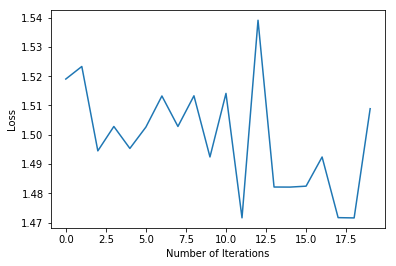

In [233]:
plt.plot(range(len(loss_list)),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

>Note: **optimizer.zero_grad()** : When we do multiple backwards passes with the same parameters, the gradients are accumulated. This means that we need to zero the gradients on each training pass or we'll retain gradients from previous training batches.

### Evaluate the model
Once the model is fit, it can be evaluated on the test dataset.

This can be achieved by using the DataLoader for the test dataset and collecting the predictions for the test set, then comparing the predictions to the expected values of the test set and calculating a performance metric.

In [235]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

/Users/adas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Accuracy of the network on the 10000 test images: 96.16 %


### Save the model checkpoint

In [143]:
torch.save(model.state_dict(), 'model.ckpt')

## 7. Convolutional Neural Network

In [ ]:
## Model

x_train_28x28 = train_data.reshape(train_data.shape[0], 28, 28, 1)
x_test_28x28 = test_data.reshape(test_data.shape[0], 28, 28, 1)

model = Sequential() 
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=50, input_dim=128, activation='relu')) 
model.add(Dense(units=10, input_dim=50, activation='softmax')) 

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_28x28, train_labels_b, batch_size=25, epochs=10, verbose=1, validation_data=(x_test_28x28, test_labels_b))
score = model.evaluate(x_test_28x28, test_labels_b, verbose=0)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])